In [ ]:
!pip install -q -U watermark

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.


In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 4.0 MB 4.9 MB/s 
     |████████████████████████████████| 77 kB 4.4 MB/s 
     |████████████████████████████████| 6.6 MB 40.4 MB/s 
     |████████████████████████████████| 596 kB 70.7 MB/s 
     |████████████████████████████████| 895 kB 39.6 MB/s 


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy       : 1.21.5
pandas      : 1.3.5
torch       : 1.10.0+cu111
transformers: 4.18.0



# IMPORT LIBRARY

In [ ]:
import transformers
from transformers import BertTokenizer, BertConfig, BertPreTrainedModel
from transformers.modeling_outputs import BaseModelOutputWithPoolingAndCrossAttentions
from transformers.models.bert.modeling_bert import (BertEmbeddings,
                                                    BertEncoder,
                                                    BertPooler,
                                                    )
from transformers import AdamW, get_linear_schedule_with_warmup

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# Create the bert configuration.
MODEL_NAME = 'cahya/bert-base-indonesian-522M'
bert_configuraiton = BertConfig.from_pretrained(MODEL_NAME)
 
# Let's see number of layers.
print('NUMBER OF LAYERS:', bert_configuraiton.num_hidden_layers)
 
# We can also see the size of embeddings inside Bert.
print('EMBEDDING SIZE:', bert_configuraiton.hidden_size)
 
# See which activation function used in hidden layers.
print('ACTIVATIONS:', bert_configuraiton.hidden_act)

# See which activation function used in hidden layers.
print('is_decoder:', bert_configuraiton.is_decoder)

Downloading:   0%|          | 0.00/468 [00:00<?, ?B/s]

NUMBER OF LAYERS: 12
EMBEDDING SIZE: 768
ACTIVATIONS: gelu
is_decoder: False


# LOAD DATASET

In [ ]:
df = pd.read_csv("/content/idiom-ta-kalimat-dataset.csv", encoding = 'unicode_escape')
df.head()

,kalimat,kategori,frasa idiom,validasi,sumber
0,Orang tua itu rela membanting tulang demi meny...,kalimat_idiom,membanting tulang,idiom,https://tirto.id/pengertian-idiom-dalam-bahasa...
1,Rusmi jadi buah bibir setelah menjuarai lomba ...,kalimat_idiom,buah bibir,idiom,https://www.medcom.id/pendidikan/news-pendidik...
2,Gara-gara pandemi covid-19 usaha Doyok harus g...,kalimat_idiom,gulung tikar,idiom,https://www.medcom.id/pendidikan/news-pendidik...
3,Saat pandemi ini Esti harus banting tulang unt...,kalimat_idiom,banting tulang,idiom,https://www.medcom.id/pendidikan/news-pendidik...
4,"Karena pandemi Covid-19, restoran Pak Hilman a...",kalimat_idiom,gulung tikar,idiom,https://xerpihan.id/blog/770/apa-itu-idiom-pen...


In [ ]:
df.shape

(2000, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   kalimat      2000 non-null   object
 1   kategori     2000 non-null   object
 2   frasa idiom  2000 non-null   object
 3   validasi     2000 non-null   object
 4   sumber       2000 non-null   object
dtypes: object(5)
memory usage: 78.2+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


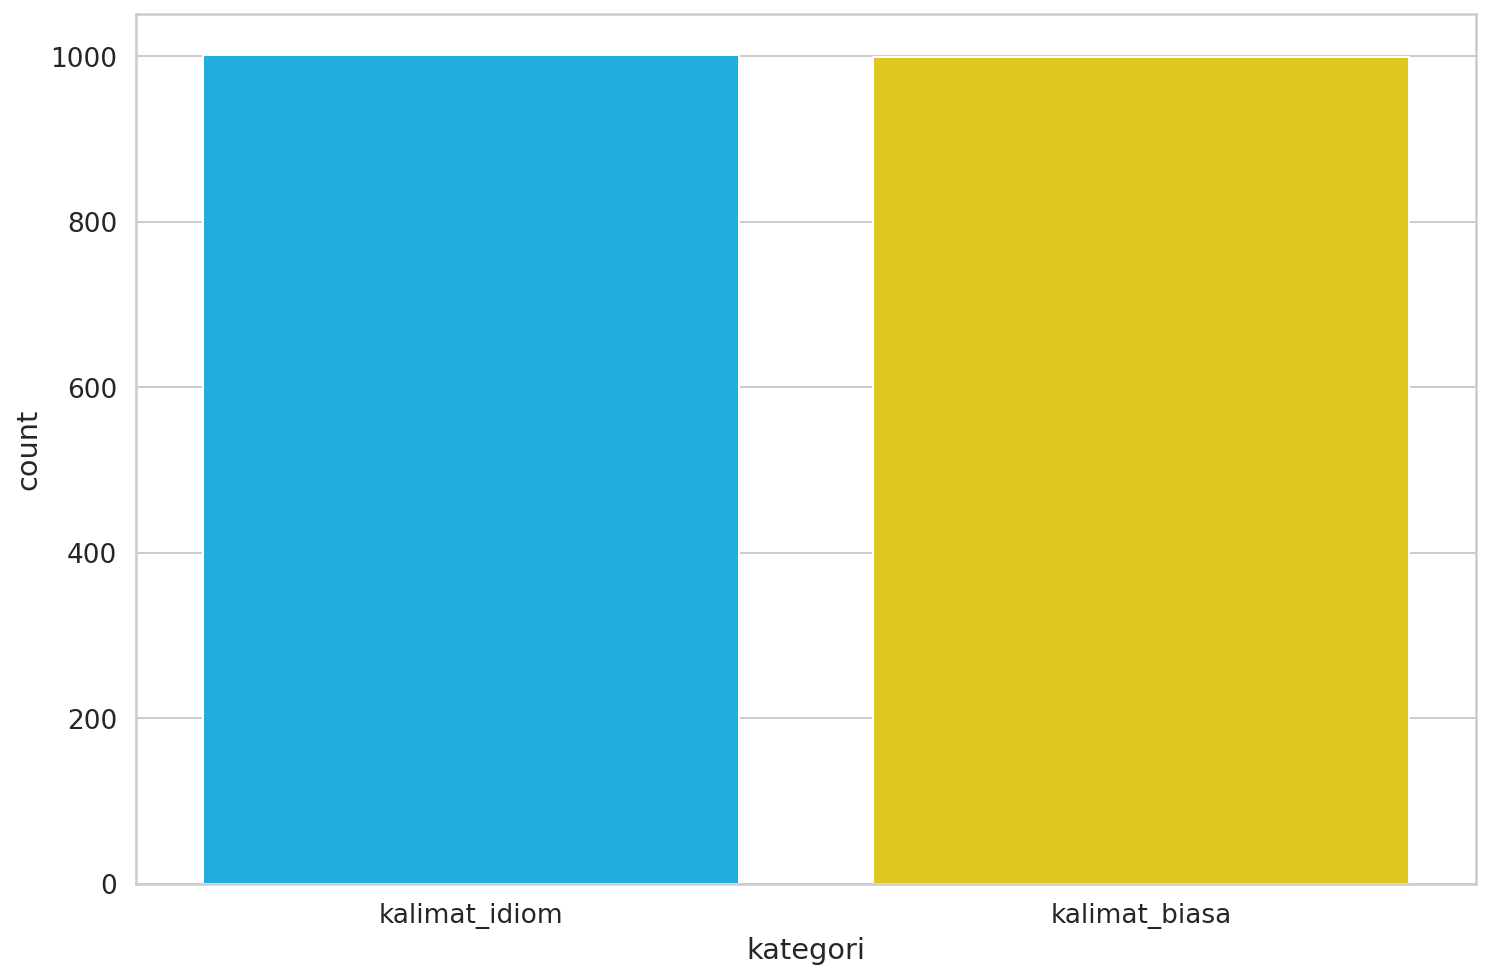

In [ ]:
sns.countplot(df.kategori)
plt.xlabel('kategori');

# PREPROCESSING

In [ ]:
label_cat = {"kategori":{'kalimat_biasa' : 0, 'kalimat_idiom' : 1}}
df = df.replace(label_cat)
df.head()

,kalimat,kategori,frasa idiom,validasi,sumber
0,Orang tua itu rela membanting tulang demi meny...,1,membanting tulang,idiom,https://tirto.id/pengertian-idiom-dalam-bahasa...
1,Rusmi jadi buah bibir setelah menjuarai lomba ...,1,buah bibir,idiom,https://www.medcom.id/pendidikan/news-pendidik...
2,Gara-gara pandemi covid-19 usaha Doyok harus g...,1,gulung tikar,idiom,https://www.medcom.id/pendidikan/news-pendidik...
3,Saat pandemi ini Esti harus banting tulang unt...,1,banting tulang,idiom,https://www.medcom.id/pendidikan/news-pendidik...
4,"Karena pandemi Covid-19, restoran Pak Hilman a...",1,gulung tikar,idiom,https://xerpihan.id/blog/770/apa-itu-idiom-pen...


## Bert Tokenisasi Example

In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

In [ ]:
(tokenizer.sep_token, tokenizer.sep_token_id), (tokenizer.cls_token, tokenizer.cls_token_id), (tokenizer.pad_token, tokenizer.pad_token_id), (tokenizer.unk_token, tokenizer.unk_token_id)

(('[SEP]', 1), ('[CLS]', 3), ('[PAD]', 2), ('[UNK]', 0))

In [ ]:
sample_txt = 'Dion adalah anak emas dari guru matematika itu.'

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  padding='max_length',
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
token_ids = encoding['input_ids'][0]
attention_mask = encoding['attention_mask'][0]
type_ids = encoding['token_type_ids'][0]
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Input Ids: {token_ids}')
print(f'Token Type Ids: {type_ids}')
print(f'Attention Mask: {attention_mask}')

 Sentence: Dion adalah anak emas dari guru matematika itu.
   Tokens: ['[CLS]', 'dion', 'adalah', 'anak', 'emas', 'dari', 'guru', 'matematika', 'itu', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Input Ids: tensor([    3, 18565,  1566,  1942,  4166,  1533,  3546,  6616,  1675,    17,
            1,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2])
Token Type Ids: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


## Choosing sequence length

In [ ]:
token_lens = []

for txt in df.kalimat:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


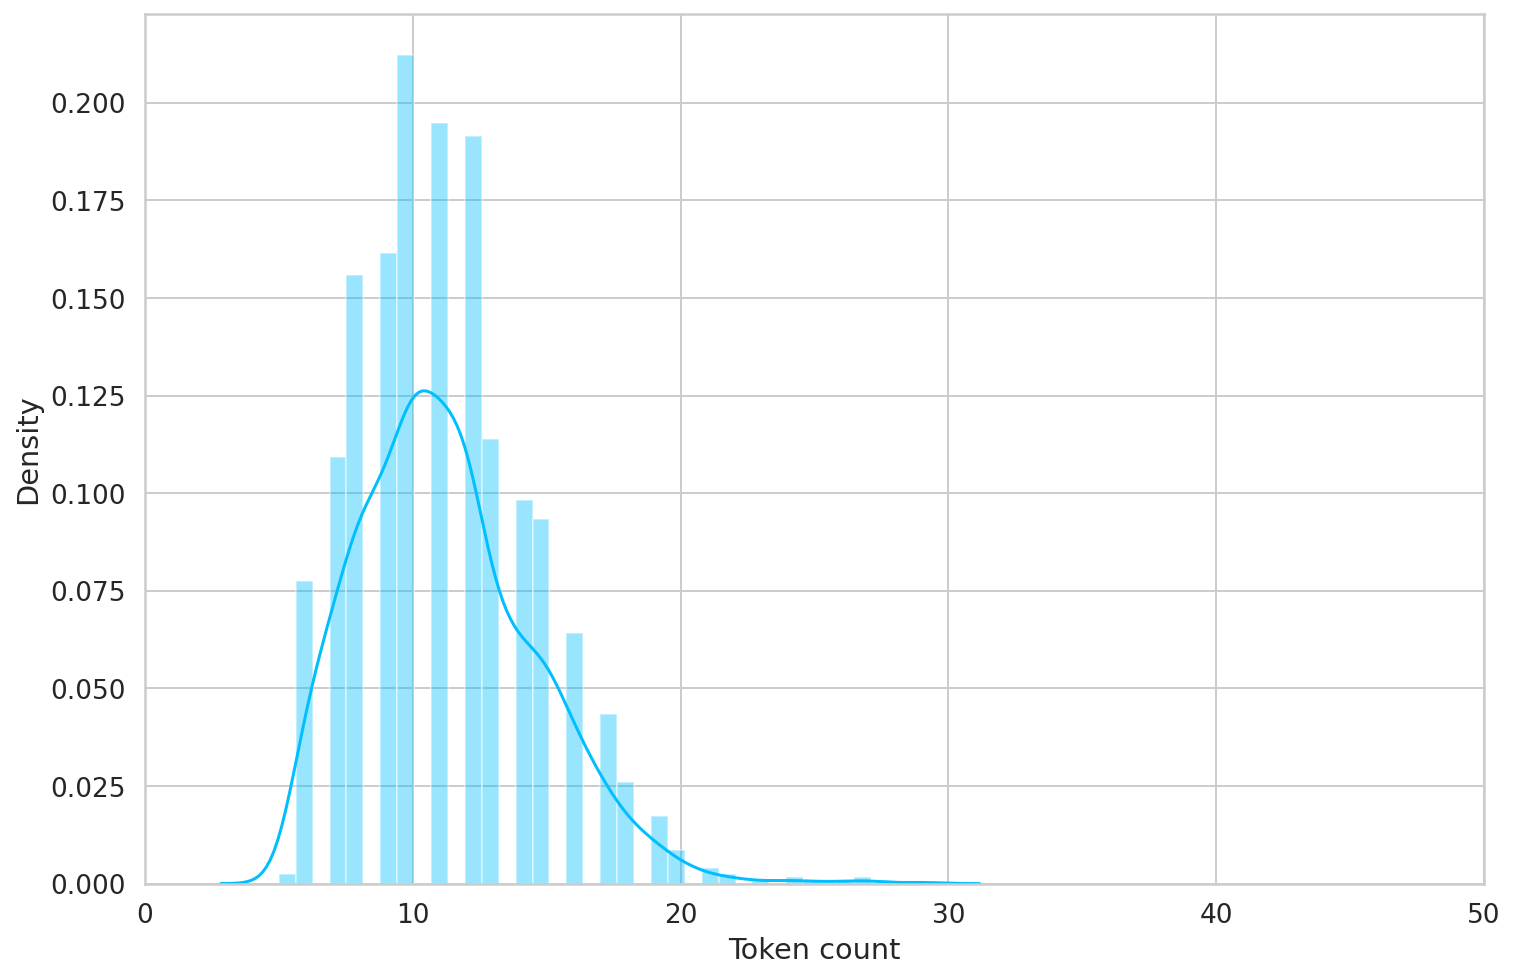

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 50]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 40

## Data Preparation

In [ ]:
class BertTokenize(Dataset):

  def __init__(self, texts, labels, tokenizer, max_len):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    text = str(self.texts[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=True,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'token_type_ids': encoding['token_type_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = BertTokenize(
    texts=df.kalimat.to_numpy(),
    labels=df.kategori.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)

In [ ]:
df_train.shape, df_test.shape

((1600, 5), (400, 5))

In [ ]:
BATCH_SIZE = 16
# train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(test_data_loader))
data.keys()

dict_keys(['text', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'])

# BERT MODEL

In [ ]:
class BertModel(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.config = config
 
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
 
        self.pooler = BertPooler(config)
 
        self.init_weights()
 
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        output_attentions = self.config.output_attentions
        
        output_hidden_states = self.config.output_hidden_states
        return_dict = return_dict
 
        use_cache = False
 
        if input_ids is not None:
            input_shape = input_ids.size()
            batch_size, seq_length = input_shape
 
        device = input_ids.device
        past_key_values_length = 0
        extended_attention_mask: torch.Tensor = self.get_extended_attention_mask(attention_mask, input_shape, device)
        encoder_extended_attention_mask = encoder_attention_mask
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)
 
        embedding_output = self.embeddings(
            input_ids=input_ids,
            position_ids=position_ids,
            token_type_ids=token_type_ids,
            inputs_embeds=inputs_embeds,
            past_key_values_length=past_key_values_length,
        )
        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_extended_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output)
 
        if not return_dict:
            return (sequence_output, pooled_output) + encoder_outputs[1:]
 
        return BaseModelOutputWithPoolingAndCrossAttentions(
            last_hidden_state=sequence_output,
            pooler_output=pooled_output,
            past_key_values=encoder_outputs.past_key_values,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
            cross_attentions=encoder_outputs.cross_attentions,
        )

# BERT CLASSIFIER

In [ ]:
class  BertClassifier(nn.Module):

  def __init__(self, n_classes, dropout=0.3):
    super(BertClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(MODEL_NAME)
    self.drop = nn.Dropout(p=dropout)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask, token_type_ids):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids,
      return_dict=False
    )
    output = self.drop(pooled_output)
    logits = self.out(output)
    classifier = torch.nn.functional.softmax(logits, dim=1)
    _, pred = torch.max(classifier, dim=1)
    return logits, pred

In [ ]:
class_names = ['kalimat_biasa', 'kalimat_idiom']
model = BertClassifier(len(class_names), 0.5)
model = model.to(device)

Some weights of the model checkpoint at cahya/bert-base-indonesian-522M were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

# EVALUATION

# Training

## Epoch = 3

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

### lr=2e-4

#### parameter

In [ ]:
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=2e-4, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.453125
precission 0.453125
recall 1.0
f1score 0.6236559139784946
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            175
kalimat_idiom              0            145
----------
accuracy 0.503125
precission 0.0
recall 0.0
f1score 0.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            161              0
kalimat_idiom            159              0
----------
accuracy 0.49375
precission 0.0
recall 0.0
f1score 0.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            158              0
kalimat_idiom            162              0
----------
accuracy 0.475
precission 0.0
recall 0.0
f1score 0.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            152              0
kalimat_idiom            168              0
----------
accuracy 0.484375
precission 0.0
recall 0.0
f1score 0.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            155              0
kalimat_idiom            165     

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.453125,0.453125,1.0,0.623656
2,0.503125,0.000000,0.0,0.000000
3,0.493750,0.000000,0.0,0.000000
4,0.475000,0.000000,0.0,0.000000
5,0.484375,0.000000,0.0,0.000000
Rata-Rata,0.481875,0.090625,0.2,0.124731


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.49625935162094764
precission 0.0
recall 0.0
f1score 0.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            199              0
kalimat_idiom            202              0


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch3lr2e-4.bin')

### lr=3e-4


#### parameter

In [ ]:
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=3e-4, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.453125
precission 0.453125
recall 1.0
f1score 0.6236559139784946
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            175
kalimat_idiom              0            145
----------
accuracy 0.496875
precission 0.496875
recall 1.0
f1score 0.6638830897703549
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            161
kalimat_idiom              0            159
----------
accuracy 0.49375
precission 0.0
recall 0.0
f1score 0.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            158              0
kalimat_idiom            162              0
----------
accuracy 0.525
precission 0.525
recall 1.0
f1score 0.6885245901639345
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            152
kalimat_idiom              0            168
----------
accuracy 0.515625
precission 0.515625
recall 1.0
f1score 0.6804123711340206
               kalimat_biasa  kalimat_idiom
kalimat_biasa       

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.453125,0.453125,1.0,0.623656
2,0.496875,0.496875,1.0,0.663883
3,0.493750,0.000000,0.0,0.000000
4,0.525000,0.525000,1.0,0.688525
5,0.515625,0.515625,1.0,0.680412
Rata-Rata,0.496875,0.398125,0.8,0.531295


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.5037406483790524
precission 0.5037406483790524
recall 1.0
f1score 0.669983416252073
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            199
kalimat_idiom              0            202


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch3lr3e-4.bin')

### lr=2e-5

#### parameter

In [ ]:
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.909375
precission 0.8766233766233766
recall 0.9310344827586207
f1score 0.9030100334448159
               kalimat_biasa  kalimat_idiom
kalimat_biasa            156             19
kalimat_idiom             10            135
----------
accuracy 0.96875
precission 0.9685534591194969
recall 0.9685534591194969
f1score 0.9685534591194969
               kalimat_biasa  kalimat_idiom
kalimat_biasa            156              5
kalimat_idiom              5            154
----------
accuracy 0.9875
precission 0.9817073170731707
recall 0.9938271604938271
f1score 0.9877300613496932
               kalimat_biasa  kalimat_idiom
kalimat_biasa            155              3
kalimat_idiom              1            161
----------
accuracy 0.990625
precission 1.0
recall 0.9821428571428571
f1score 0.9909909909909909
               kalimat_biasa  kalimat_idiom
kalimat_biasa            152              0
kalimat_idiom              3            165
----------
accuracy 1.0
precission 1.0
rec

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.909375,0.876623,0.931034,0.903010
2,0.968750,0.968553,0.968553,0.968553
3,0.987500,0.981707,0.993827,0.987730
4,0.990625,1.000000,0.982143,0.990991
5,1.000000,1.000000,1.000000,1.000000
Rata-Rata,0.971250,0.965377,0.975112,0.970057


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.9675810473815462
precission 0.9796954314720813
recall 0.9554455445544554
f1score 0.9674185463659148
               kalimat_biasa  kalimat_idiom
kalimat_biasa            195              4
kalimat_idiom              9            193


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch3lr2e-5.bin')

### lr=3e-5

#### parameter

In [ ]:
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.921875
precission 0.9545454545454546
recall 0.8689655172413793
f1score 0.9097472924187726
               kalimat_biasa  kalimat_idiom
kalimat_biasa            169              6
kalimat_idiom             19            126
----------
accuracy 0.965625
precission 0.9743589743589743
recall 0.9559748427672956
f1score 0.9650793650793651
               kalimat_biasa  kalimat_idiom
kalimat_biasa            157              4
kalimat_idiom              7            152
----------
accuracy 0.990625
precission 0.9818181818181818
recall 1.0
f1score 0.9908256880733944
               kalimat_biasa  kalimat_idiom
kalimat_biasa            155              3
kalimat_idiom              0            162
----------
accuracy 0.990625
precission 0.9940119760479041
recall 0.9880952380952381
f1score 0.991044776119403
               kalimat_biasa  kalimat_idiom
kalimat_biasa            151              1
kalimat_idiom              2            166
----------
accuracy 0.9875
precission 0.

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.921875,0.954545,0.868966,0.909747
2,0.965625,0.974359,0.955975,0.965079
3,0.990625,0.981818,1.000000,0.990826
4,0.990625,0.994012,0.988095,0.991045
5,0.987500,0.993865,0.981818,0.987805
Rata-Rata,0.971250,0.979720,0.958971,0.968900


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.9576059850374065
precission 0.9743589743589743
recall 0.9405940594059405
f1score 0.9571788413098237
               kalimat_biasa  kalimat_idiom
kalimat_biasa            194              5
kalimat_idiom             12            190


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch3lr3e-5.bin')

### lr=2e-6

#### parameter

In [ ]:
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=2e-6, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.88125
precission 0.8689655172413793
recall 0.8689655172413793
f1score 0.8689655172413793
               kalimat_biasa  kalimat_idiom
kalimat_biasa            156             19
kalimat_idiom             19            126
----------
accuracy 0.934375
precission 0.9791666666666666
recall 0.8867924528301887
f1score 0.9306930693069307
               kalimat_biasa  kalimat_idiom
kalimat_biasa            158              3
kalimat_idiom             18            141
----------
accuracy 0.9875
precission 0.9759036144578314
recall 1.0
f1score 0.9878048780487805
               kalimat_biasa  kalimat_idiom
kalimat_biasa            154              4
kalimat_idiom              0            162
----------
accuracy 0.99375
precission 1.0
recall 0.9880952380952381
f1score 0.9940119760479043
               kalimat_biasa  kalimat_idiom
kalimat_biasa            152              0
kalimat_idiom              2            166
----------
accuracy 0.99375
precission 0.9939393939393939


In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.881250,0.868966,0.868966,0.868966
2,0.934375,0.979167,0.886792,0.930693
3,0.987500,0.975904,1.000000,0.987805
4,0.993750,1.000000,0.988095,0.994012
5,0.993750,0.993939,0.993939,0.993939
Rata-Rata,0.958125,0.963595,0.947559,0.955083


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.9825436408977556
precission 0.9850746268656716
recall 0.9801980198019802
f1score 0.9826302729528535
               kalimat_biasa  kalimat_idiom
kalimat_biasa            196              3
kalimat_idiom              4            198


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch3lr2e-6.bin')

### lr=3e-6

#### parameter

In [ ]:
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=3e-6, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.86875
precission 0.8410596026490066
recall 0.8758620689655172
f1score 0.8581081081081081
               kalimat_biasa  kalimat_idiom
kalimat_biasa            151             24
kalimat_idiom             18            127
----------
accuracy 0.9375
precission 0.9727891156462585
recall 0.89937106918239
f1score 0.934640522875817
               kalimat_biasa  kalimat_idiom
kalimat_biasa            157              4
kalimat_idiom             16            143
----------
accuracy 0.990625
precission 0.9877300613496932
recall 0.9938271604938271
f1score 0.9907692307692307
               kalimat_biasa  kalimat_idiom
kalimat_biasa            156              2
kalimat_idiom              1            161
----------
accuracy 0.99375
precission 1.0
recall 0.9880952380952381
f1score 0.9940119760479043
               kalimat_biasa  kalimat_idiom
kalimat_biasa            152              0
kalimat_idiom              2            166
----------
accuracy 0.99375
precission 1.0
rec

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.868750,0.841060,0.875862,0.858108
2,0.937500,0.972789,0.899371,0.934641
3,0.990625,0.987730,0.993827,0.990769
4,0.993750,1.000000,0.988095,0.994012
5,0.993750,1.000000,0.987879,0.993902
Rata-Rata,0.956875,0.960316,0.949007,0.954286


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.9675810473815462
precission 0.9896373056994818
recall 0.9455445544554455
f1score 0.9670886075949366
               kalimat_biasa  kalimat_idiom
kalimat_biasa            197              2
kalimat_idiom             11            191


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch3lr3e-6.bin')

## Epoch = 4

### lr=2e-4

#### parameter

In [ ]:
EPOCHS = 4
optimizer = AdamW(model.parameters(), lr=2e-4, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.496875
precission 0.496875
recall 1.0
f1score 0.6638830897703549
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            161
kalimat_idiom              0            159
----------
accuracy 0.50625
precission 0.0
recall 0.0
f1score 0.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            162              0
kalimat_idiom            158              0
----------
accuracy 0.5
precission 0.0
recall 0.0
f1score 0.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            160              0
kalimat_idiom            160              0
----------
accuracy 0.48125
precission 0.0
recall 0.0
f1score 0.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            154              0
kalimat_idiom            166              0
----------
accuracy 0.503125
precission 0.0
recall 0.0
f1score 0.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            161              0
kalimat_idiom            159        

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.496875,0.496875,1.0,0.663883
2,0.506250,0.000000,0.0,0.000000
3,0.500000,0.000000,0.0,0.000000
4,0.481250,0.000000,0.0,0.000000
5,0.503125,0.000000,0.0,0.000000
Rata-Rata,0.497500,0.099375,0.2,0.132777


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.49625935162094764
precission 0.0
recall 0.0
f1score 0.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            199              0
kalimat_idiom            202              0


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch3lr2e-4.bin')

### lr=3e-4


#### parameter

In [ ]:
EPOCHS = 4
optimizer = AdamW(model.parameters(), lr=3e-4, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.496875
precission 0.496875
recall 1.0
f1score 0.6638830897703549
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            161
kalimat_idiom              0            159
----------
accuracy 0.49375
precission 0.49375
recall 1.0
f1score 0.6610878661087867
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            162
kalimat_idiom              0            158
----------
accuracy 0.5
precission 0.5
recall 1.0
f1score 0.6666666666666666
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            160
kalimat_idiom              0            160
----------
accuracy 0.51875
precission 0.51875
recall 1.0
f1score 0.6831275720164609
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            154
kalimat_idiom              0            166
----------
accuracy 0.496875
precission 0.496875
recall 1.0
f1score 0.6638830897703549
               kalimat_biasa  kalimat_idiom
kalimat

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.496875,0.496875,1.0,0.663883
2,0.493750,0.493750,1.0,0.661088
3,0.500000,0.500000,1.0,0.666667
4,0.518750,0.518750,1.0,0.683128
5,0.496875,0.496875,1.0,0.663883
Rata-Rata,0.501250,0.501250,1.0,0.667730


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.4975
precission 0.4975
recall 1.0
f1score 0.664440734557596
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            201
kalimat_idiom              0            199


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch3lr3e-4.bin')

### lr=2e-5

#### parameter

In [ ]:
EPOCHS = 4
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.875
precission 0.8082901554404145
recall 0.9811320754716981
f1score 0.8863636363636364
               kalimat_biasa  kalimat_idiom
kalimat_biasa            124             37
kalimat_idiom              3            156
----------
accuracy 0.971875
precission 0.9570552147239264
recall 0.9873417721518988
f1score 0.9719626168224299
               kalimat_biasa  kalimat_idiom
kalimat_biasa            155              7
kalimat_idiom              2            156
----------
accuracy 0.9875
precission 1.0
recall 0.975
f1score 0.9873417721518987
               kalimat_biasa  kalimat_idiom
kalimat_biasa            160              0
kalimat_idiom              4            156
----------
accuracy 0.996875
precission 1.0
recall 0.9939759036144579
f1score 0.9969788519637462
               kalimat_biasa  kalimat_idiom
kalimat_biasa            154              0
kalimat_idiom              1            165
----------
accuracy 1.0
precission 1.0
recall 1.0
f1score 1.0
          

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.875000,0.808290,0.981132,0.886364
2,0.971875,0.957055,0.987342,0.971963
3,0.987500,1.000000,0.975000,0.987342
4,0.996875,1.000000,0.993976,0.996979
5,1.000000,1.000000,1.000000,1.000000
Rata-Rata,0.966250,0.953069,0.987490,0.968529


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.9725
precission 0.9607843137254902
recall 0.9849246231155779
f1score 0.9727047146401986
               kalimat_biasa  kalimat_idiom
kalimat_biasa            193              8
kalimat_idiom              3            196


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch3lr2e-5.bin')

### lr=3e-5

#### parameter

In [ ]:
EPOCHS = 4
optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.89375
precission 0.8342245989304813
recall 0.9811320754716981
f1score 0.9017341040462428
               kalimat_biasa  kalimat_idiom
kalimat_biasa            130             31
kalimat_idiom              3            156
----------
accuracy 0.971875
precission 0.9745222929936306
recall 0.9683544303797469
f1score 0.9714285714285714
               kalimat_biasa  kalimat_idiom
kalimat_biasa            158              4
kalimat_idiom              5            153
----------
accuracy 0.96875
precission 0.9807692307692307
recall 0.95625
f1score 0.9683544303797469
               kalimat_biasa  kalimat_idiom
kalimat_biasa            157              3
kalimat_idiom              7            153
----------
accuracy 0.9875
precission 1.0
recall 0.9759036144578314
f1score 0.9878048780487805
               kalimat_biasa  kalimat_idiom
kalimat_biasa            154              0
kalimat_idiom              4            162
----------
accuracy 0.996875
precission 1.0
recall 0.9

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.893750,0.834225,0.981132,0.901734
2,0.971875,0.974522,0.968354,0.971429
3,0.968750,0.980769,0.956250,0.968354
4,0.987500,1.000000,0.975904,0.987805
5,0.996875,1.000000,0.993711,0.996845
Rata-Rata,0.963750,0.957903,0.975070,0.965233


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.9775
precission 0.9702970297029703
recall 0.9849246231155779
f1score 0.9775561097256857
               kalimat_biasa  kalimat_idiom
kalimat_biasa            195              6
kalimat_idiom              3            196


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch3lr3e-5.bin')

### lr=2e-6

#### parameter

In [ ]:
EPOCHS = 4
optimizer = AdamW(model.parameters(), lr=2e-6, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.896875
precission 0.9038461538461539
recall 0.8867924528301887
f1score 0.8952380952380953
               kalimat_biasa  kalimat_idiom
kalimat_biasa            146             15
kalimat_idiom             18            141
----------
accuracy 0.959375
precission 0.967741935483871
recall 0.9493670886075949
f1score 0.9584664536741213
               kalimat_biasa  kalimat_idiom
kalimat_biasa            157              5
kalimat_idiom              8            150
----------
accuracy 0.98125
precission 1.0
recall 0.9625
f1score 0.980891719745223
               kalimat_biasa  kalimat_idiom
kalimat_biasa            160              0
kalimat_idiom              6            154
----------
accuracy 1.0
precission 1.0
recall 1.0
f1score 1.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            154              0
kalimat_idiom              0            166
----------
accuracy 0.99375
precission 1.0
recall 0.9874213836477987
f1score 0.9936708860759493
        

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.896875,0.903846,0.886792,0.895238
2,0.959375,0.967742,0.949367,0.958466
3,0.981250,1.000000,0.962500,0.980892
4,1.000000,1.000000,1.000000,1.000000
5,0.993750,1.000000,0.987421,0.993671
Rata-Rata,0.966250,0.974318,0.957216,0.965653


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.985
precission 0.9753694581280788
recall 0.9949748743718593
f1score 0.9850746268656716
               kalimat_biasa  kalimat_idiom
kalimat_biasa            196              5
kalimat_idiom              1            198


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch3lr2e-6.bin')

### lr=3e-6

#### parameter

In [ ]:
EPOCHS = 4
optimizer = AdamW(model.parameters(), lr=3e-6, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.903125
precission 0.872093023255814
recall 0.9433962264150944
f1score 0.9063444108761329
               kalimat_biasa  kalimat_idiom
kalimat_biasa            139             22
kalimat_idiom              9            150
----------
accuracy 0.96875
precission 0.9625
recall 0.9746835443037974
f1score 0.9685534591194969
               kalimat_biasa  kalimat_idiom
kalimat_biasa            156              6
kalimat_idiom              4            154
----------
accuracy 0.99375
precission 1.0
recall 0.9875
f1score 0.9937106918238994
               kalimat_biasa  kalimat_idiom
kalimat_biasa            160              0
kalimat_idiom              2            158
----------
accuracy 1.0
precission 1.0
recall 1.0
f1score 1.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            154              0
kalimat_idiom              0            166
----------
accuracy 0.996875
precission 1.0
recall 0.9937106918238994
f1score 0.9968454258675079
               kali

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.903125,0.872093,0.943396,0.906344
2,0.968750,0.962500,0.974684,0.968553
3,0.993750,1.000000,0.987500,0.993711
4,1.000000,1.000000,1.000000,1.000000
5,0.996875,1.000000,0.993711,0.996845
Rata-Rata,0.972500,0.966919,0.979858,0.973091


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.9675810473815462
precission 0.9896373056994818
recall 0.9455445544554455
f1score 0.9670886075949366
               kalimat_biasa  kalimat_idiom
kalimat_biasa            197              2
kalimat_idiom             11            191


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch3lr3e-6.bin')

## Epoch = 5

### lr=2e-4

#### parameter

In [ ]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-4, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.453125
precission 0.453125
recall 1.0
f1score 0.6236559139784946
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            175
kalimat_idiom              0            145
----------
accuracy 0.503125
precission 0.0
recall 0.0
f1score 0.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            161              0
kalimat_idiom            159              0
----------
accuracy 0.49375
precission 0.0
recall 0.0
f1score 0.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            158              0
kalimat_idiom            162              0
----------
accuracy 0.525
precission 0.525
recall 1.0
f1score 0.6885245901639345
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            152
kalimat_idiom              0            168
----------
accuracy 0.484375
precission 0.0
recall 0.0
f1score 0.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            155              0
kalimat_idiom   

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.453125,0.453125,1.0,0.623656
2,0.503125,0.000000,0.0,0.000000
3,0.493750,0.000000,0.0,0.000000
4,0.525000,0.525000,1.0,0.688525
5,0.484375,0.000000,0.0,0.000000
Rata-Rata,0.491875,0.195625,0.4,0.262436


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.49625935162094764
precission 0.0
recall 0.0
f1score 0.0


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch5lr2e-4.bin')

### lr=3e-4


#### parameter

In [ ]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=3e-4, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.453125
precission 0.453125
recall 1.0
f1score 0.6236559139784946
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            175
kalimat_idiom              0            145
----------
accuracy 0.496875
precission 0.496875
recall 1.0
f1score 0.6638830897703549
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            161
kalimat_idiom              0            159
----------
accuracy 0.50625
precission 0.50625
recall 1.0
f1score 0.6721991701244813
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            158
kalimat_idiom              0            162
----------
accuracy 0.525
precission 0.525
recall 1.0
f1score 0.6885245901639345
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            152
kalimat_idiom              0            168
----------
accuracy 0.515625
precission 0.515625
recall 1.0
f1score 0.6804123711340206
               kalimat_biasa  kalimat_idiom
k

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.453125,0.453125,1.0,0.623656
2,0.496875,0.496875,1.0,0.663883
3,0.506250,0.506250,1.0,0.672199
4,0.525000,0.525000,1.0,0.688525
5,0.515625,0.515625,1.0,0.680412
Rata-Rata,0.499375,0.499375,1.0,0.665735


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.5037406483790524
precission 0.5037406483790524
recall 1.0
f1score 0.669983416252073
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            199
kalimat_idiom              0            202


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch5lr3e-4.bin')

### lr=2e-5

#### parameter

In [ ]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.95625
precission 0.9395973154362416
recall 0.9655172413793104
f1score 0.9523809523809523
               kalimat_biasa  kalimat_idiom
kalimat_biasa            166              9
kalimat_idiom              5            140
----------
accuracy 0.96875
precission 0.9745222929936306
recall 0.9622641509433962
f1score 0.9683544303797469
               kalimat_biasa  kalimat_idiom
kalimat_biasa            157              4
kalimat_idiom              6            153
----------
accuracy 0.984375
precission 0.9875776397515528
recall 0.9814814814814815
f1score 0.9845201238390092
               kalimat_biasa  kalimat_idiom
kalimat_biasa            156              2
kalimat_idiom              3            159
----------
accuracy 0.99375
precission 1.0
recall 0.9880952380952381
f1score 0.9940119760479043
               kalimat_biasa  kalimat_idiom
kalimat_biasa            152              0
kalimat_idiom              2            166
----------
accuracy 0.996875
precission 0.

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.956250,0.939597,0.965517,0.952381
2,0.968750,0.974522,0.962264,0.968354
3,0.984375,0.987578,0.981481,0.984520
4,0.993750,1.000000,0.988095,0.994012
5,0.996875,0.993976,1.000000,0.996979
Rata-Rata,0.980000,0.979135,0.979472,0.979249


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.9750623441396509
precission 0.9660194174757282
recall 0.9851485148514851
f1score 0.9754901960784313
               kalimat_biasa  kalimat_idiom
kalimat_biasa            192              7
kalimat_idiom              3            199


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch5lr2e-5.bin')

### lr=3e-5

#### parameter

In [ ]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.940625
precission 0.9565217391304348
recall 0.9103448275862069
f1score 0.9328621908127209
               kalimat_biasa  kalimat_idiom
kalimat_biasa            169              6
kalimat_idiom             13            132
----------
accuracy 0.95
precission 0.9554140127388535
recall 0.9433962264150944
f1score 0.949367088607595
               kalimat_biasa  kalimat_idiom
kalimat_biasa            154              7
kalimat_idiom              9            150
----------
accuracy 0.946875
precission 0.9050279329608939
recall 1.0
f1score 0.9501466275659824
               kalimat_biasa  kalimat_idiom
kalimat_biasa            141             17
kalimat_idiom              0            162
----------
accuracy 0.98125
precission 0.9764705882352941
recall 0.9880952380952381
f1score 0.9822485207100591
               kalimat_biasa  kalimat_idiom
kalimat_biasa            148              4
kalimat_idiom              2            166
----------
accuracy 0.99375
precission 0.9939

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.940625,0.956522,0.910345,0.932862
2,0.950000,0.955414,0.943396,0.949367
3,0.946875,0.905028,1.000000,0.950147
4,0.981250,0.976471,0.988095,0.982249
5,0.993750,0.993939,0.993939,0.993939
Rata-Rata,0.962500,0.957475,0.967155,0.961713


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.9551122194513716
precission 0.9466019417475728
recall 0.9653465346534653
f1score 0.9558823529411764
               kalimat_biasa  kalimat_idiom
kalimat_biasa            188             11
kalimat_idiom              7            195


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch5lr3e-5.bin')

### lr=2e-6

#### parameter

In [ ]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-6, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.85625
precission 0.8074534161490683
recall 0.896551724137931
f1score 0.8496732026143792
               kalimat_biasa  kalimat_idiom
kalimat_biasa            144             31
kalimat_idiom             15            130
----------
accuracy 0.9375
precission 0.9727891156462585
recall 0.89937106918239
f1score 0.934640522875817
               kalimat_biasa  kalimat_idiom
kalimat_biasa            157              4
kalimat_idiom             16            143
----------
accuracy 0.975
precission 0.98125
recall 0.9691358024691358
f1score 0.9751552795031055
               kalimat_biasa  kalimat_idiom
kalimat_biasa            155              3
kalimat_idiom              5            157
----------
accuracy 0.996875
precission 1.0
recall 0.9940476190476191
f1score 0.9970149253731343
               kalimat_biasa  kalimat_idiom
kalimat_biasa            152              0
kalimat_idiom              1            167
----------
accuracy 0.990625
precission 0.9939024390243902
r

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.856250,0.807453,0.896552,0.849673
2,0.937500,0.972789,0.899371,0.934641
3,0.975000,0.981250,0.969136,0.975155
4,0.996875,1.000000,0.994048,0.997015
5,0.990625,0.993902,0.987879,0.990881
Rata-Rata,0.951250,0.951079,0.949397,0.949473


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.9850374064837906
precission 0.9803921568627451
recall 0.9900990099009901
f1score 0.9852216748768472
               kalimat_biasa  kalimat_idiom
kalimat_biasa            195              4
kalimat_idiom              2            200


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch5lr2e-6.bin')

### lr=3e-6

#### parameter

In [ ]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=3e-6, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.90625
precission 0.9078014184397163
recall 0.8827586206896552
f1score 0.8951048951048951
               kalimat_biasa  kalimat_idiom
kalimat_biasa            162             13
kalimat_idiom             17            128
----------
accuracy 0.971875
precission 0.9807692307692307
recall 0.9622641509433962
f1score 0.9714285714285713
               kalimat_biasa  kalimat_idiom
kalimat_biasa            158              3
kalimat_idiom              6            153
----------
accuracy 0.996875
precission 1.0
recall 0.9938271604938271
f1score 0.9969040247678018
               kalimat_biasa  kalimat_idiom
kalimat_biasa            158              0
kalimat_idiom              1            161
----------
accuracy 0.996875
precission 1.0
recall 0.9940476190476191
f1score 0.9970149253731343
               kalimat_biasa  kalimat_idiom
kalimat_biasa            152              0
kalimat_idiom              1            167
----------
accuracy 0.996875
precission 1.0
recall 0.99

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.906250,0.907801,0.882759,0.895105
2,0.971875,0.980769,0.962264,0.971429
3,0.996875,1.000000,0.993827,0.996904
4,0.996875,1.000000,0.994048,0.997015
5,0.996875,1.000000,0.993939,0.996960
Rata-Rata,0.973750,0.977714,0.965367,0.971483


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.9875311720698254
precission 0.9949748743718593
recall 0.9801980198019802
f1score 0.9875311720698253
               kalimat_biasa  kalimat_idiom
kalimat_biasa            198              1
kalimat_idiom              4            198


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch5lr3e-6.bin')

## Epoch = 6

### lr=2e-4

#### parameter

In [ ]:
EPOCHS = 6
optimizer = AdamW(model.parameters(), lr=2e-4, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.496875
precission 0.496875
recall 1.0
f1score 0.6638830897703549
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            161
kalimat_idiom              0            159
----------
accuracy 0.50625
precission 0.0
recall 0.0
f1score 0.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            162              0
kalimat_idiom            158              0
----------
accuracy 0.5
precission 0.0
recall 0.0
f1score 0.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            160              0
kalimat_idiom            160              0
----------
accuracy 0.48125
precission 0.0
recall 0.0
f1score 0.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            154              0
kalimat_idiom            166              0
----------
accuracy 0.503125
precission 0.0
recall 0.0
f1score 0.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            161              0
kalimat_idiom            159        

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.496875,0.496875,1.0,0.663883
2,0.506250,0.000000,0.0,0.000000
3,0.500000,0.000000,0.0,0.000000
4,0.481250,0.000000,0.0,0.000000
5,0.503125,0.000000,0.0,0.000000
Rata-Rata,0.497500,0.099375,0.2,0.132777


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.49625935162094764
precission 0.0
recall 0.0
f1score 0.0


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch6lr2e-4.bin')

### lr=3e-4


#### parameter

In [ ]:
EPOCHS = 6
optimizer = AdamW(model.parameters(), lr=3e-4, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.496875
precission 0.496875
recall 1.0
f1score 0.6638830897703549
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            161
kalimat_idiom              0            159
----------
accuracy 0.49375
precission 0.49375
recall 1.0
f1score 0.6610878661087867
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            162
kalimat_idiom              0            158
----------
accuracy 0.5
precission 0.5
recall 1.0
f1score 0.6666666666666666
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            160
kalimat_idiom              0            160
----------
accuracy 0.51875
precission 0.51875
recall 1.0
f1score 0.6831275720164609
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            154
kalimat_idiom              0            166
----------
accuracy 0.496875
precission 0.496875
recall 1.0
f1score 0.6638830897703549
               kalimat_biasa  kalimat_idiom
kalimat

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.496875,0.496875,1.0,0.663883
2,0.493750,0.493750,1.0,0.661088
3,0.500000,0.500000,1.0,0.666667
4,0.518750,0.518750,1.0,0.683128
5,0.496875,0.496875,1.0,0.663883
Rata-Rata,0.501250,0.501250,1.0,0.667730


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.5037406483790524
precission 0.5037406483790524
recall 1.0
f1score 0.669983416252073
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            199
kalimat_idiom              0            202


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch6lr3e-4.bin')

### lr=2e-5

#### parameter

In [ ]:
EPOCHS = 6
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.953125
precission 0.9337349397590361
recall 0.9748427672955975
f1score 0.9538461538461538
               kalimat_biasa  kalimat_idiom
kalimat_biasa            150             11
kalimat_idiom              4            155
----------
accuracy 0.99375
precission 0.9936708860759493
recall 0.9936708860759493
f1score 0.9936708860759493
               kalimat_biasa  kalimat_idiom
kalimat_biasa            161              1
kalimat_idiom              1            157
----------
accuracy 1.0
precission 1.0
recall 1.0
f1score 1.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            160              0
kalimat_idiom              0            160
----------
accuracy 1.0
precission 1.0
recall 1.0
f1score 1.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            154              0
kalimat_idiom              0            166
----------
accuracy 0.996875
precission 1.0
recall 0.9937106918238994
f1score 0.9968454258675079
               kalimat_biasa

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.953125,0.933735,0.974843,0.953846
2,0.993750,0.993671,0.993671,0.993671
3,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,1.000000
5,0.996875,1.000000,0.993711,0.996845
Rata-Rata,0.988750,0.985481,0.992445,0.988872


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.985
precission 0.9948717948717949
recall 0.9748743718592965
f1score 0.9847715736040609
               kalimat_biasa  kalimat_idiom
kalimat_biasa            200              1
kalimat_idiom              5            194


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch6lr2e-5.bin')

### lr=3e-5

#### parameter

In [ ]:
EPOCHS = 6
optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.915625
precission 0.8793103448275862
recall 0.9622641509433962
f1score 0.9189189189189189
               kalimat_biasa  kalimat_idiom
kalimat_biasa            140             21
kalimat_idiom              6            153
----------
accuracy 0.934375
precission 0.9858156028368794
recall 0.879746835443038
f1score 0.9297658862876255
               kalimat_biasa  kalimat_idiom
kalimat_biasa            160              2
kalimat_idiom             19            139
----------
accuracy 0.953125
precission 0.9738562091503268
recall 0.93125
f1score 0.952076677316294
               kalimat_biasa  kalimat_idiom
kalimat_biasa            156              4
kalimat_idiom             11            149
----------
accuracy 0.978125
precission 0.9818181818181818
recall 0.9759036144578314
f1score 0.9788519637462236
               kalimat_biasa  kalimat_idiom
kalimat_biasa            151              3
kalimat_idiom              4            162
----------
accuracy 0.990625
precissi

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.915625,0.879310,0.962264,0.918919
2,0.934375,0.985816,0.879747,0.929766
3,0.953125,0.973856,0.931250,0.952077
4,0.978125,0.981818,0.975904,0.978852
5,0.990625,0.981481,1.000000,0.990654
Rata-Rata,0.954375,0.960456,0.949833,0.954054


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.955
precission 0.9248826291079812
recall 0.9899497487437185
f1score 0.9563106796116505
               kalimat_biasa  kalimat_idiom
kalimat_biasa            185             16
kalimat_idiom              2            197


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch6lr3e-5.bin')

### lr=2e-6

#### parameter

In [ ]:
EPOCHS = 6
optimizer = AdamW(model.parameters(), lr=2e-6, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.871875
precission 0.8390804597701149
recall 0.9182389937106918
f1score 0.8768768768768769
               kalimat_biasa  kalimat_idiom
kalimat_biasa            133             28
kalimat_idiom             13            146
----------
accuracy 0.925
precission 0.9652777777777778
recall 0.879746835443038
f1score 0.9205298013245033
               kalimat_biasa  kalimat_idiom
kalimat_biasa            157              5
kalimat_idiom             19            139
----------
accuracy 0.96875
precission 0.993421052631579
recall 0.94375
f1score 0.967948717948718
               kalimat_biasa  kalimat_idiom
kalimat_biasa            159              1
kalimat_idiom              9            151
----------
accuracy 0.99375
precission 1.0
recall 0.9879518072289156
f1score 0.993939393939394
               kalimat_biasa  kalimat_idiom
kalimat_biasa            154              0
kalimat_idiom              2            164
----------
accuracy 0.996875
precission 1.0
recall 0.993710

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.871875,0.839080,0.918239,0.876877
2,0.925000,0.965278,0.879747,0.920530
3,0.968750,0.993421,0.943750,0.967949
4,0.993750,1.000000,0.987952,0.993939
5,0.996875,1.000000,0.993711,0.996845
Rata-Rata,0.951250,0.959556,0.944680,0.951228


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.9850374064837906
precission 0.9803921568627451
recall 0.9900990099009901
f1score 0.9852216748768472
               kalimat_biasa  kalimat_idiom
kalimat_biasa            195              4
kalimat_idiom              2            200


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch6lr2e-6.bin')

### lr=3e-6

#### parameter

In [ ]:
EPOCHS = 6
optimizer = AdamW(model.parameters(), lr=3e-6, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.915625
precission 0.888235294117647
recall 0.949685534591195
f1score 0.9179331306990881
               kalimat_biasa  kalimat_idiom
kalimat_biasa            142             19
kalimat_idiom              8            151
----------
accuracy 0.9625
precission 0.9802631578947368
recall 0.9430379746835443
f1score 0.9612903225806452
               kalimat_biasa  kalimat_idiom
kalimat_biasa            159              3
kalimat_idiom              9            149
----------
accuracy 0.99375
precission 1.0
recall 0.9875
f1score 0.9937106918238994
               kalimat_biasa  kalimat_idiom
kalimat_biasa            160              0
kalimat_idiom              2            158
----------
accuracy 0.99375
precission 0.9939759036144579
recall 0.9939759036144579
f1score 0.9939759036144579
               kalimat_biasa  kalimat_idiom
kalimat_biasa            153              1
kalimat_idiom              1            165
----------
accuracy 0.996875
precission 1.0
recall 0.9937

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.915625,0.888235,0.949686,0.917933
2,0.962500,0.980263,0.943038,0.961290
3,0.993750,1.000000,0.987500,0.993711
4,0.993750,0.993976,0.993976,0.993976
5,0.996875,1.000000,0.993711,0.996845
Rata-Rata,0.972500,0.972495,0.973582,0.972751


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.98
precission 0.9847715736040609
recall 0.9748743718592965
f1score 0.9797979797979797
               kalimat_biasa  kalimat_idiom
kalimat_biasa            198              3
kalimat_idiom              5            194


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch6lr3e-6.bin')

## Epoch = 7

### lr=2e-4

#### parameter

In [ ]:
EPOCHS = 7
optimizer = AdamW(model.parameters(), lr=2e-4, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.496875
precission 0.496875
recall 1.0
f1score 0.6638830897703549
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            161
kalimat_idiom              0            159
----------
accuracy 0.50625
precission 0.0
recall 0.0
f1score 0.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            162              0
kalimat_idiom            158              0
----------
accuracy 0.5
precission 0.0
recall 0.0
f1score 0.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            160              0
kalimat_idiom            160              0
----------
accuracy 0.48125
precission 0.0
recall 0.0
f1score 0.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            154              0
kalimat_idiom            166              0
----------
accuracy 0.503125
precission 0.0
recall 0.0
f1score 0.0
               kalimat_biasa  kalimat_idiom
kalimat_biasa            161              0
kalimat_idiom            159        

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.496875,0.496875,1.0,0.663883
2,0.506250,0.000000,0.0,0.000000
3,0.500000,0.000000,0.0,0.000000
4,0.481250,0.000000,0.0,0.000000
5,0.503125,0.000000,0.0,0.000000
Rata-Rata,0.497500,0.099375,0.2,0.132777


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.49625935162094764
precission 0.0
recall 0.0
f1score 0.0


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch7lr2e-4.bin')

### lr=3e-4


#### parameter

In [ ]:
EPOCHS = 7
optimizer = AdamW(model.parameters(), lr=3e-4, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.496875
precission 0.496875
recall 1.0
f1score 0.6638830897703549
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            161
kalimat_idiom              0            159
----------
accuracy 0.49375
precission 0.49375
recall 1.0
f1score 0.6610878661087867
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            162
kalimat_idiom              0            158
----------
accuracy 0.5
precission 0.5
recall 1.0
f1score 0.6666666666666666
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            160
kalimat_idiom              0            160
----------
accuracy 0.51875
precission 0.51875
recall 1.0
f1score 0.6831275720164609
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            154
kalimat_idiom              0            166
----------
accuracy 0.496875
precission 0.496875
recall 1.0
f1score 0.6638830897703549
               kalimat_biasa  kalimat_idiom
kalimat

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.496875,0.496875,1.0,0.663883
2,0.493750,0.493750,1.0,0.661088
3,0.500000,0.500000,1.0,0.666667
4,0.518750,0.518750,1.0,0.683128
5,0.496875,0.496875,1.0,0.663883
Rata-Rata,0.501250,0.501250,1.0,0.667730


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.5037406483790524
precission 0.5037406483790524
recall 1.0
f1score 0.669983416252073
               kalimat_biasa  kalimat_idiom
kalimat_biasa              0            199
kalimat_idiom              0            202


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch7lr3e-4.bin')

### lr=2e-5

#### parameter

In [ ]:
EPOCHS = 7
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.959375
precission 0.9294117647058824
recall 0.9937106918238994
f1score 0.9604863221884499
               kalimat_biasa  kalimat_idiom
kalimat_biasa            149             12
kalimat_idiom              1            158
----------
accuracy 0.990625
precission 0.9813664596273292
recall 1.0
f1score 0.9905956112852665
               kalimat_biasa  kalimat_idiom
kalimat_biasa            159              3
kalimat_idiom              0            158
----------
accuracy 0.99375
precission 0.99375
recall 0.99375
f1score 0.99375
               kalimat_biasa  kalimat_idiom
kalimat_biasa            159              1
kalimat_idiom              1            159
----------
accuracy 0.996875
precission 1.0
recall 0.9939759036144579
f1score 0.9969788519637462
               kalimat_biasa  kalimat_idiom
kalimat_biasa            154              0
kalimat_idiom              1            165
----------
accuracy 0.996875
precission 1.0
recall 0.9937106918238994
f1score 0.99684542

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.959375,0.929412,0.993711,0.960486
2,0.990625,0.981366,1.000000,0.990596
3,0.993750,0.993750,0.993750,0.993750
4,0.996875,1.000000,0.993976,0.996979
5,0.996875,1.000000,0.993711,0.996845
Rata-Rata,0.987500,0.980906,0.995029,0.987731


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.975
precission 0.9846153846153847
recall 0.964824120603015
f1score 0.9746192893401016
               kalimat_biasa  kalimat_idiom
kalimat_biasa            198              3
kalimat_idiom              7            192


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch7lr2e-5.bin')

### lr=3e-5

#### parameter

In [ ]:
EPOCHS = 7
optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.909375
precission 0.877906976744186
recall 0.949685534591195
f1score 0.9123867069486405
               kalimat_biasa  kalimat_idiom
kalimat_biasa            140             21
kalimat_idiom              8            151
----------
accuracy 0.98125
precission 0.9691358024691358
recall 0.9936708860759493
f1score 0.9812500000000001
               kalimat_biasa  kalimat_idiom
kalimat_biasa            157              5
kalimat_idiom              1            157
----------
accuracy 0.96875
precission 0.993421052631579
recall 0.94375
f1score 0.967948717948718
               kalimat_biasa  kalimat_idiom
kalimat_biasa            159              1
kalimat_idiom              9            151
----------
accuracy 0.975
precission 0.9876543209876543
recall 0.963855421686747
f1score 0.975609756097561
               kalimat_biasa  kalimat_idiom
kalimat_biasa            152              2
kalimat_idiom              6            160
----------
accuracy 0.996875
precission 1.0
re

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.909375,0.877907,0.949686,0.912387
2,0.981250,0.969136,0.993671,0.981250
3,0.968750,0.993421,0.943750,0.967949
4,0.975000,0.987654,0.963855,0.975610
5,0.996875,1.000000,0.993711,0.996845
Rata-Rata,0.966250,0.965624,0.968935,0.966808


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.9551122194513716
precission 0.9466019417475728
recall 0.9653465346534653
f1score 0.9558823529411764
               kalimat_biasa  kalimat_idiom
kalimat_biasa            188             11
kalimat_idiom              7            195


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch7lr3e-5.bin')

### lr=2e-6

#### parameter

In [ ]:
EPOCHS = 7
optimizer = AdamW(model.parameters(), lr=2e-6, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.859375
precission 0.8238636363636364
recall 0.9119496855345912
f1score 0.8656716417910448
               kalimat_biasa  kalimat_idiom
kalimat_biasa            130             31
kalimat_idiom             14            145
----------
accuracy 0.94375
precission 0.9666666666666667
recall 0.9177215189873418
f1score 0.9415584415584415
               kalimat_biasa  kalimat_idiom
kalimat_biasa            157              5
kalimat_idiom             13            145
----------
accuracy 0.96875
precission 0.993421052631579
recall 0.94375
f1score 0.967948717948718
               kalimat_biasa  kalimat_idiom
kalimat_biasa            159              1
kalimat_idiom              9            151
----------
accuracy 0.99375
precission 1.0
recall 0.9879518072289156
f1score 0.993939393939394
               kalimat_biasa  kalimat_idiom
kalimat_biasa            154              0
kalimat_idiom              2            164
----------
accuracy 0.996875
precission 1.0
recall 0.993

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.859375,0.823864,0.911950,0.865672
2,0.943750,0.966667,0.917722,0.941558
3,0.968750,0.993421,0.943750,0.967949
4,0.993750,1.000000,0.987952,0.993939
5,0.996875,1.000000,0.993711,0.996845
Rata-Rata,0.952500,0.956790,0.951017,0.953193


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.9850374064837906
precission 0.9803921568627451
recall 0.9900990099009901
f1score 0.9852216748768472
               kalimat_biasa  kalimat_idiom
kalimat_biasa            195              4
kalimat_idiom              2            200


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch7lr2e-6.bin')

### lr=3e-6

#### parameter

In [ ]:
EPOCHS = 7
optimizer = AdamW(model.parameters(), lr=3e-6, correct_bias=False)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
  )

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    labels = d["labels"].to(device)

    output, preds = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    loss = loss_fn(output, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      labels = d["labels"].to(device)

      output, preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      
      loss = loss_fn(output, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())


  return preds

#### training

In [ ]:
#kfold Cross Validation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

acc = []
precission = []
recall = []
f1score = []

n=5
kf = KFold(n_splits=n, random_state=1, shuffle=True)

for train_index, val_index in kf.split(df_train):

  train_df = df_train.iloc[train_index]
  val_df = df_train.iloc[val_index]

  train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, len(val_df))

  train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(train_df)
  )

  prediction = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  label = val_df['kategori'].values.tolist()

  val_acc = accuracy_score(label, prediction)
  acc.append(val_acc)

  val_precission = precision_score(label, prediction)
  precission.append(val_precission)

  val_recall = recall_score(label, prediction)
  recall.append(val_recall)

  val_f1score = f1_score(label, prediction)
  f1score.append(val_f1score)

  print('-' * 10)
  print(f'accuracy {val_acc}')
  print(f'precission {val_precission}')
  print(f'recall {val_recall}')
  print(f'f1score {val_f1score}')
  print(pd.DataFrame(confusion_matrix(label, prediction), index=class_names, columns=class_names))


mean_acc = sum(acc) / len(acc)
mean_precission = sum(precission) / len(precission)
mean_recall = sum(recall) / len(recall)
mean_f1score = sum(f1score) / len(f1score)

print('-' * 10)
print(f"Mean-Accuracy: {mean_acc}")
print(f"Mean-Precision: {mean_precission}")
print(f"Mean-Recall: {mean_recall}")
print(f"Mean-F1score: {mean_f1score}")

----------
accuracy 0.91875
precission 0.893491124260355
recall 0.949685534591195
f1score 0.9207317073170732
               kalimat_biasa  kalimat_idiom
kalimat_biasa            143             18
kalimat_idiom              8            151
----------
accuracy 0.98125
precission 0.9691358024691358
recall 0.9936708860759493
f1score 0.9812500000000001
               kalimat_biasa  kalimat_idiom
kalimat_biasa            157              5
kalimat_idiom              1            157
----------
accuracy 0.99375
precission 1.0
recall 0.9875
f1score 0.9937106918238994
               kalimat_biasa  kalimat_idiom
kalimat_biasa            160              0
kalimat_idiom              2            158
----------
accuracy 0.996875
precission 1.0
recall 0.9939759036144579
f1score 0.9969788519637462
               kalimat_biasa  kalimat_idiom
kalimat_biasa            154              0
kalimat_idiom              1            165
----------
accuracy 0.996875
precission 1.0
recall 0.9937106918238994
f

In [ ]:
acc_df = pd.DataFrame(acc,index =['1', '2', '3', '4', '5'], columns =['Accuracy'])
precission_df = pd.DataFrame(precission,index =['1', '2', '3', '4', '5'], columns =['Precission'])
recall_df = pd.DataFrame(recall,index =['1', '2', '3', '4', '5'], columns =['Recall'])
f1score_df = pd.DataFrame(f1score,index =['1', '2', '3', '4', '5'], columns =['F1-score'])

list_mean = [[mean_acc, mean_precission, mean_recall, mean_f1score]]
mean_df = pd.DataFrame(list_mean,index =['Rata-Rata'], columns =['Accuracy','Precission','Recall', 'F1-score'])

evaluasi = pd.concat([acc_df, precission_df, recall_df, f1score_df], axis=1)
evaluasi_fix = pd.concat([evaluasi, mean_df], axis=0)
evaluasi_fix

,Accuracy,Precission,Recall,F1-score
1,0.918750,0.893491,0.949686,0.920732
2,0.981250,0.969136,0.993671,0.981250
3,0.993750,1.000000,0.987500,0.993711
4,0.996875,1.000000,0.993976,0.996979
5,0.996875,1.000000,0.993711,0.996845
Rata-Rata,0.977500,0.972525,0.983709,0.977903


#### testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_acc = accuracy_score(y_test, y_pred)
test_precission = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1score = f1_score(y_test, y_pred)

print('-' * 10)
print(f'accuracy {test_acc}')
print(f'precission {test_precission}')
print(f'recall {test_recall}')
print(f'f1score {test_f1score}')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names))

----------
accuracy 0.9875311720698254
precission 0.9949748743718593
recall 0.9801980198019802
f1score 0.9875311720698253
               kalimat_biasa  kalimat_idiom
kalimat_biasa            198              1
kalimat_idiom              4            198


#### saving model

In [ ]:
torch.save(model.state_dict(), 'epoch7lr3e-6.bin')

# Testing

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d["text"]

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].to(device)

            output, preds = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids
            )

            texts.extend(text)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, real_values

In [ ]:
y_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

kalimat_biasa       0.98      0.97      0.98       199
kalimat_idiom       0.98      0.99      0.98       202

     accuracy                           0.98       401
    macro avg       0.98      0.98      0.98       401
 weighted avg       0.98      0.98      0.98       401



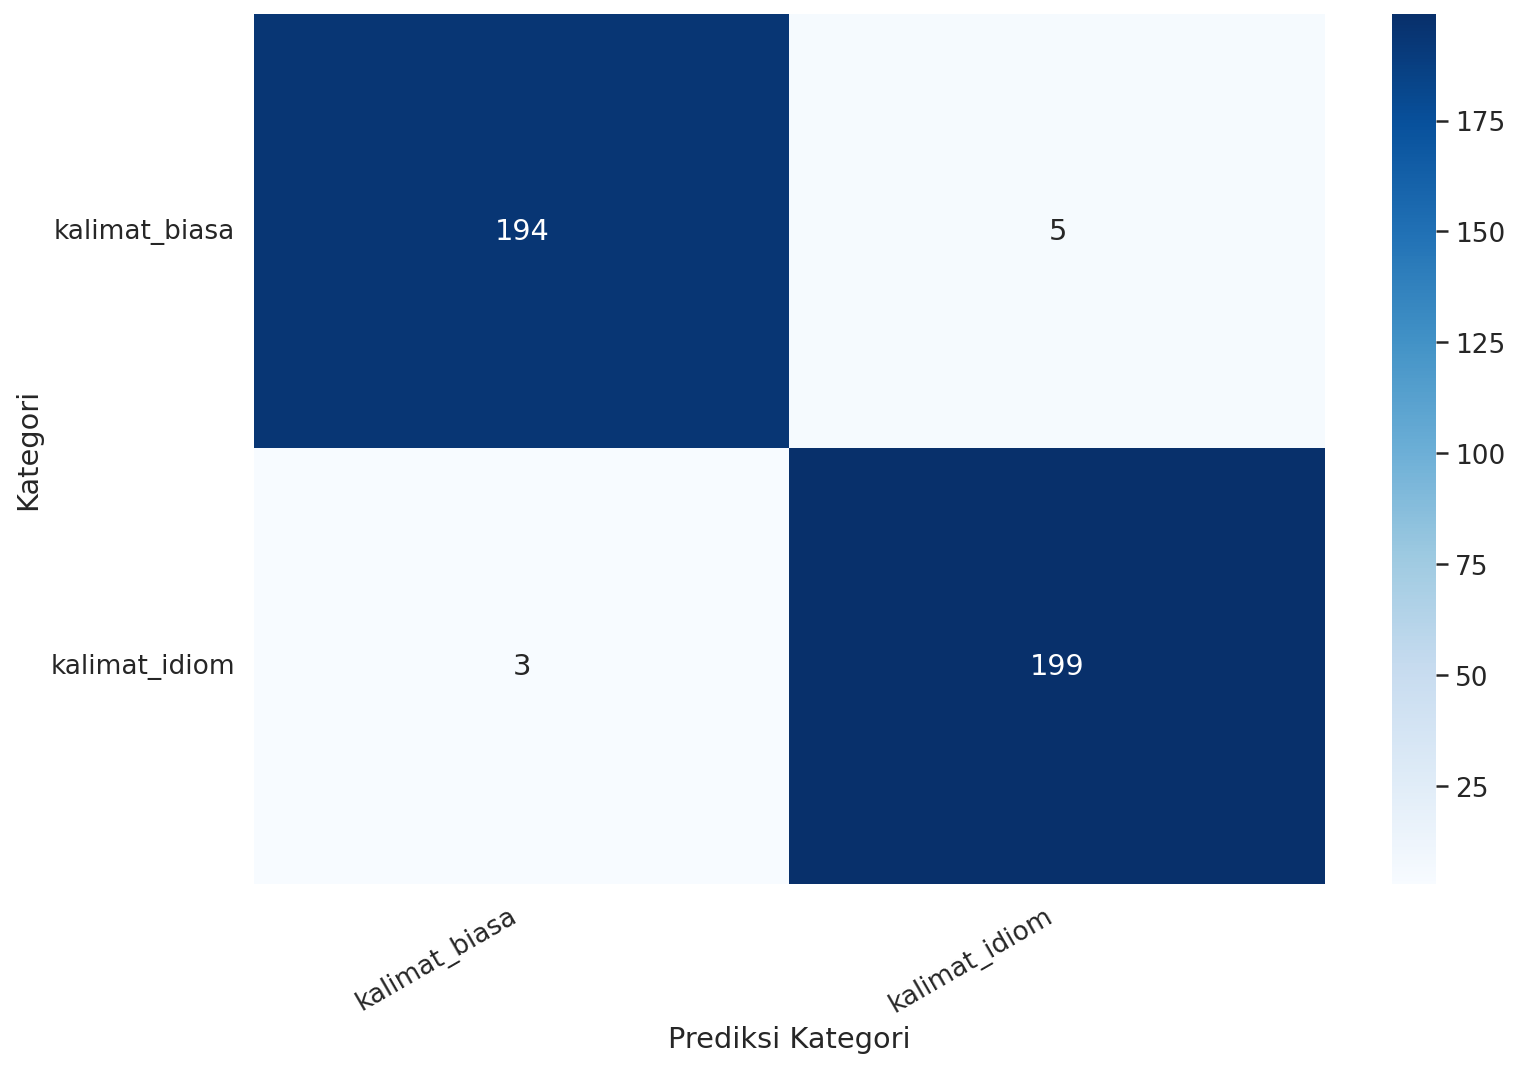

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('Kategori')
  plt.xlabel('Prediksi Kategori');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# PREDICTING RAW TEXT



In [ ]:
text = 'Dion adalah anak emas dari guru matematika itu.'

In [ ]:
encoded_text = tokenizer.encode_plus(
  text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=True,
  padding='max_length',
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
#load model
model1 = BertClassifier(len(class_names))
model1.load_state_dict(torch.load('/content/epoch5lr2e-5.bin'))
model1 = model1.to(device)

In [ ]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)
token_type_ids = encoded_text['token_type_ids'].to(device)
output, prediction= model1(input_ids, attention_mask, token_type_ids)

print(f'Text: {text}')
print(f'Label  : {class_names[prediction]}')

Text: Dion adalah anak emas dari guru matematika itu.
Label  : kalimat_idiom
